In [1]:
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [2]:
RADIUS = 50
MASSES = np.array([13.69, 22.87, 226, 27.946, 29.424, 43.2, 43.44, 16.95]) * 0.001
RADII = np.array([49, 72, 99.4, 99, 99, 125, 125, 74]) * 0.001 / 2
PUCKS = np.array([[0, 1], [0, 2], [3, 4], [5, 6], [1, 7], [1, 7]])

### Import, process data

In [3]:
files = listdir("./matningar")
datasets = []
metadata = []
for file in files:
    split = file.split("_")
    scenario = int(split[0])
    series = int(split[1].split(".")[0])
    print(scenario, series)

    data = np.loadtxt("./matningar/" + file, delimiter="\t", skiprows=11)
    vectorised = []
    for row in data:
        row_vectorised = []
        for n in range(0, 12, 3):
            row_vectorised.append([row[n] * 0.001, row[n+1] * 0.001, row[n+2] * 0.001])
        vectorised.append(row_vectorised)
    
    if len(vectorised) != 0:
        datasets.append(np.array(vectorised))
        metadata.append([scenario, series])
#datasets

1 1
1 10
1 11
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 1
2 2
2 3
2 4
2 5
2 6
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 1
5 10
5 11
5 12
5 13
5 14
5 15
5 16
5 17
5 18
5 19
5 2
5 20
5 21
5 22
5 23
5 24
5 25
5 26
5 27
5 28
5 29
5 3
5 30
5 31
5 32
5 33
5 34
5 35
5 36
5 37
5 38
5 39
5 4
5 40
5 41
5 42
5 43
5 44
5 45
5 46
5 47
5 48
5 49
5 5
5 50
5 51
5 52
5 53
5 54
5 55
5 56
5 57
5 58
5 59
5 6
5 7
5 8
5 9
6 1
6 10
6 11
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9


C:\Users\griff\AppData\Local\Temp\ipykernel_14268\2707978006.py:10: UserWarning: loadtxt: input contained no data: "./matningar/1_8.tsv"
  data = np.loadtxt("./matningar/" + file, delimiter="\t", skiprows=11)


In [4]:
def rolling_avg(x, n):
    return np.convolve(x, np.ones(n)) / n

In [5]:
def draw_measurement(pos, subsample):
    plt.scatter(pos[:,0,0][::subsample], pos[:,0,1][::subsample], s=0.5)
    plt.scatter(pos[:,1,0][::subsample], pos[:,1,1][::subsample], s=0.5)

In [6]:
# Format as vectors (x, y, r)

positions = []
for vel in datasets:
    l = []
    for frame in vel:
        pos = np.array([frame[0], frame[2]])
        diff = np.array([frame[1], frame[3]]) - pos

        angles = np.arctan(np.array([diff[0][1]/diff[0][0], diff[1][1]/diff[1][0]]))
        l.append([
            [pos[0][0], pos[0][1], angles[0]], 
            [pos[1][0], pos[1][1], angles[1]]
        ])
    l = np.array(l)
    l[:,:,2] = np.unwrap(l[:,:,2], period=np.pi, axis=0)
    positions.append(l)


# Data processing

## Velocity, acc, CoM

20


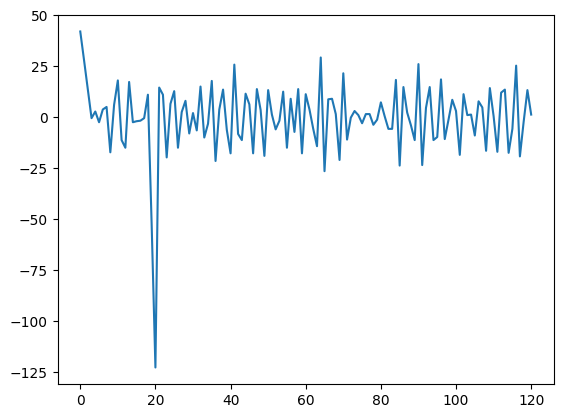

In [7]:
series = 0
velocities = []
accelerations = []
accsum = []
CoMs = []
CoM_vels = []
for (i, vel) in enumerate(positions):
    velocity = (vel[1:]-vel[:-1])*500 # 500Hz 
    acceleration = (velocity[1:]-velocity[:-1])*500
    accs = np.sqrt(acceleration[:,:,0]**2 + acceleration[:,:,1]**2)

    velocities.append(velocity)
    accelerations.append(acceleration)
    accsum.append(accs)

    mass = MASSES[PUCKS[metadata[i][0]-1]]
    CoM = (vel[:,0,[0,1]] * mass[0] + vel[:,1,[0,1]] * mass[1])/(mass[0]+mass[1])
    CoM_vel = (CoM[1:]-CoM[:-1])*500

    CoMs.append(CoM)
    CoM_vels.append(CoM_vel)
# plt.plot(accsum[series][:,0])
plt.plot(accelerations[series][:,0,0])
print(np.argmax(accsum[series][:,0] + accsum[series][:,1]))
# plt.plot(processed[28][:,0,1])

## Linear Momentum

In [8]:
linmoms = []

for (i, vel) in enumerate(velocities):
    scenario = metadata[i][0]-1
    mass = MASSES[PUCKS[scenario]]
    momentum = vel[:,:,[0,1]]
    momentum_sum = momentum[:, 0] * mass[0] + momentum[:, 1] * mass[1]
    
    linmoms.append(momentum_sum)

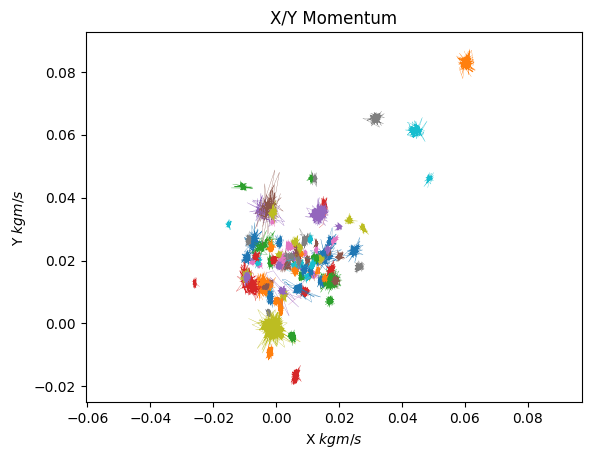

In [9]:
for mom in linmoms:
    plt.plot(mom[:,0], mom[:,1], linewidth=0.2)
plt.axis('equal')
plt.title("X/Y Momentum")
plt.xlabel("X $kgm/s$")
plt.ylabel("Y $kgm/s$")
None

## Angular Momentum

$r = v \times p = v_x p_y - v_y p_x$ 

$f = \frac{1}{2 \pi \omega}$

$L = 2 \pi M f r^2 = \frac{M r^2}{\omega}$

In [10]:
angmoms = []

for (i, (pos, vel)) in enumerate(zip(positions, velocities)):
    scenario = metadata[i][0]-1
    
    moment_of_inertia = MASSES[PUCKS[scenario]] * RADII[PUCKS[scenario]]**2 / 2
    
    angvel = vel[:,:,2]
    
    
    # Momentum around each puck's own CoM
    rotational_momentum = np.array([
        rolling_avg(angvel[:, 0] * moment_of_inertia[0], 1),
        rolling_avg(angvel[:, 1] * moment_of_inertia[1], 1)
    ]).T

    momentum_sum = rotational_momentum[:, 0] + rotational_momentum[:, 1]
    
    # Momentum around origin
    rvel =  MASSES[PUCKS[scenario]] * (vel[:,:,1]*pos[1:,:,0] - vel[:,:,0]*pos[1:,:,1]) # [m1, m2] * [vy*px]
    
    angmom_sum = rvel[:, 0] + rvel[:, 1] + momentum_sum

    angmoms.append(rotational_momentum + rvel)

    # plt.plot(rvel[:,0]+rvel[:,1])
    # plt.plot(rvel + angular_momentum)

    # plt.scatter(momentum_sum[:,0], momentum_sum[:,1], label=i, s=0.1)
    
    # plt.plot(momentum[:, 0, 0], momentum[:, 0, 1])
    # plt.plot(momentum[:, 1, 0], momentum[:, 1, 1])

    # plt.plot(angvel[:,0])
    # plt.plot(angular_momentum[:,0], linewidth=1, label = "A: " + str(metadata[i][0]) + "_" + str(metadata[i][1]))
    # plt.plot(angular_momentum[:,1], linewidth=1, label = "B: " + str(metadata[i][0]) + "_" + str(metadata[i][1]))
# plt.xlim(-0.1, 0.1)
# plt.ylim(-0.1, 0.1)
# plt.legend()
# plt.title("Total Angular Momentum")
# plt.xlabel("X $kgm/s$")
# plt.ylabel("rad/s")
None

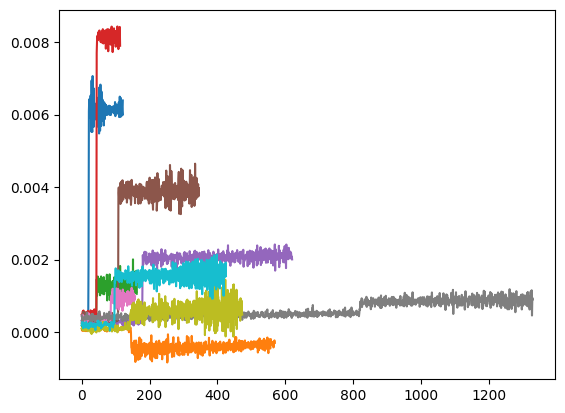

In [11]:
for mom in angmoms[0:10]:
    plt.plot(mom[:,1])

## Impact detection

In [12]:
impact_times = []
acc_sqs = []
for acc in accelerations:
    # Sum the squares of x, y accelerations for both pucks
    acc_sq = acc[:,0,0]**2+acc[:,0,1]**2+acc[:,1,0]**2+acc[:,1,1]**2
    acc_sqs.append(acc_sq)
    impact_times.append(np.argmax(acc_sq))

In [13]:
margin = 5
for (linmom, angmom, impact_time) in zip(linmoms, angmoms, impact_times):
    linavg_pre = np.average(linmom[:impact_time - margin], axis=0)
    linavg_post = np.average(linmom[impact_time + margin:], axis=0)
    
    angavg_pre = np.average(angmom[:impact_time - margin], axis=0)
    angavg_post = np.average(angmom[impact_time + margin:], axis=0)
    
    # print(np.sum(angavg_post)/np.sum(angavg_pre))

## $\alpha$ - $\omega$ relationship

In [21]:
for (pos, vel, impact_time, meta) in zip(positions[4:5], velocities[4:5], impact_times[4:5], metadata[4:5]):
    # Velocities from puck B:s frame of referencef
    scenario = meta[0]

    avg_vel = np.average(vel[:impact_time - 5], axis = 0)
    relative_vel = avg_vel[0]-avg_vel[1]
    vel_angle = np.arctan2(relative_vel[1], relative_vel[0])
    relative_pos_at_impact = -(pos[impact_time,0]-pos[impact_time,1])
    contact_angle = np.arctan2(relative_pos_at_impact[1], relative_pos_at_impact[0])
    
    draw_measurement(pos, 15)
    
    plt.arrow(pos[impact_time,0,0], pos[impact_time, 0, 1], relative_pos_at_impact[0]/2, relative_pos_at_impact[1]/2, color="green")
    plt.arrow(pos[impact_time,0,0], pos[impact_time, 0, 1], relative_vel[0]/100, relative_vel[1]/100, color="red")
    plt.axis("equal")

    puck_a_surface_velocity = np.array([-np.sin(contact_angle), np.cos(contact_angle)]) * RADII[PUCKS[scenario][0]] * avg_vel[0][2] + relative_vel[0:2]
    puck_b_surface_velocity = -np.array([-np.sin(contact_angle), np.cos(contact_angle)]) * RADII[PUCKS[scenario][1]] * avg_vel[1][2]
    relative_surface_velocity = puck_a_surface_velocity - puck_b_surface_velocity

    # print(vel_angle, contact_angle)

IndexError: invalid index to scalar variable.

## Trash

In [15]:
ordered_datasets = []
for vel in datasets:
    mindistances = np.ones([4,4])*99999
    distance = np.zeros([4,4])
    lastdistance = np.zeros([4,4])

    

    distancechangesum = np.zeros([4,4])

    for x in range(0, 4):
        for y in range(0, x+1):
            distancechangesum[x][y]=-1

    velocities = []
    for (a,b) in zip(vel, vel[1:]):
        velocities.append(b-a)
    
    #acceleration_sum = np.zeros(4)
    #for (a,b) in zip(velocities, velocities[1:]):
    #    for n in range(0,4):
    #        acceleration_sum[n] += np.linalg.norm(b[n]-a[n])
    

    for (i, row) in enumerate(vel):
        for x in range(0, 4):
            for y in range(x+1, 4):
                distance[x][y] = np.linalg.norm(row[x]-row[y])
        
        mindistances = np.minimum(mindistances, distance)
        if i > 0:
            distancechangesum += np.abs(distance-lastdistance)
        lastdistance = np.copy(distance)

    diffmax = np.max(distancechangesum)

    pair_a = (-1,-1)
    pair_b = (0,0)

    while True:
        idx = np.unravel_index(np.argmin(distancechangesum), distancechangesum.shape)
        if distancechangesum[idx] != -1:
            if pair_a == (-1,-1):
                pair_a = idx
            else:
                pair_b = idx
                break
        distancechangesum[idx] = diffmax

    print("CoM/edge pairs:", pair_a, pair_b)

    set_new = [[],[],[],[]]

    for row in vel:
        set_new[0].append(row[pair_a[0]])
        set_new[1].append(row[pair_a[1]])
        set_new[2].append(row[pair_b[0]])
        set_new[3].append(row[pair_b[1]])
    
    print(vel)
    print("###")
    print(np.array(set_new))
    #print(ordered_datasets[0])

CoM/edge pairs: (0, 1) (2, 3)
[[[ 0.258327  0.202371 -0.011777]
  [ 0.250994  0.183359 -0.009272]
  [ 0.273299  0.343456 -0.013206]
  [ 0.305279  0.346714 -0.013233]]

 [[ 0.258226  0.206275 -0.012336]
  [ 0.251064  0.187742 -0.009673]
  [ 0.27321   0.343447 -0.013201]
  [ 0.305217  0.346712 -0.013215]]

 [[ 0.258293  0.21003  -0.01257 ]
  [ 0.250995  0.192218 -0.010325]
  [ 0.273122  0.343451 -0.013195]
  [ 0.305145  0.346719 -0.013213]]

 ...

 [[ 0.226158  0.264075 -0.012682]
  [ 0.213092  0.248692 -0.012652]
  [ 0.302623  0.577631 -0.012479]
  [ 0.334518  0.573449 -0.012414]]

 [[ 0.225817  0.263874 -0.01269 ]
  [ 0.212661  0.248542 -0.012648]
  [ 0.302948  0.579993 -0.012502]
  [ 0.334815  0.57563  -0.012283]]

 [[ 0.225481  0.263698 -0.01281 ]
  [ 0.21222   0.248449 -0.012653]
  [ 0.303237  0.582399 -0.012526]
  [ 0.33507   0.577928 -0.012229]]]
###
[[[ 0.258327  0.202371 -0.011777]
  [ 0.258226  0.206275 -0.012336]
  [ 0.258293  0.21003  -0.01257 ]
  ...
  [ 0.226158  0.264075 -

In [16]:
xyr_sets = []
for vel in ordered_datasets:
    xyr = []
    for row in vel:
        print(row)
        diff_a = row[1]-row[0]
        diff_b = row[3]-row[2]
        xyr.append([[
            row[0][0],
            row[0][1],
            np.arctan2(diff_a[1], diff_a[0])
        ],[
            row[2][0],
            row[2][1],
            np.arctan2(diff_b[1], diff_b[0])
        ]])
    xyr_sets.append(np.array(xyr))

print(xyr_sets)

[]


In [17]:
files = listdir("./data")
datasets = []
for file in files:
    data = np.loadtxt("./data/" + file, delimiter="\t")
    vectorised = []
    for row in data:
        row_vectorised = []
        for n in range(2, 10, 2):
            row_vectorised.append([row[n], row[n+1]])
        vectorised.append(row_vectorised)
    datasets.append(np.array(vectorised))

# Visualisation

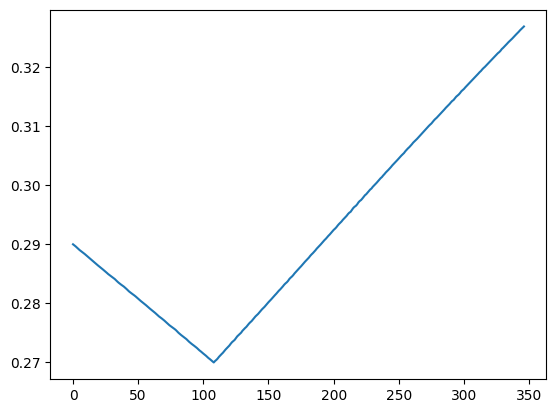

In [18]:
series = 5
puck = 1
# plt.plot(rolling_avg(processed[series][:,puck][:,2][:-1] - processed[series][:,puck][:,2][1:], 5))
# plt.ylim(-0.005, 0.01)
# plt.plot(processed[series][:,1][:,2])
plt.plot(positions[series][:,0][:,0])
None

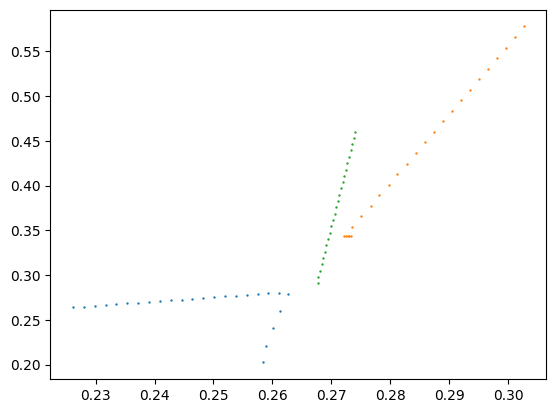

In [19]:
series = 0
subsample = 5
plt.scatter(positions[series][:,0,0][::subsample], positions[series][:,0,1][::subsample], s=0.5)
plt.scatter(positions[series][:,1,0][::subsample], positions[series][:,1,1][::subsample], s=0.5)
plt.scatter(CoMs[series][:,0][::subsample], CoMs[series][:,1][::subsample], s=0.5)